# How good is your Github Readme

# 1. Github Scraping
For collecting the initial dataset using the Github API. Collect up to 1000 repo readme's for the top 10 programming languages.

In [ ]:
from github3 import login, GitHub
from github3.null import NullObject
from getpass import getpass, getuser
import os.path
import sys
import json
import time

def saveResults(fileName, jsonObject):
    f = open(fileName, "w")
    f.write(json.dumps(jsonObject))
    f.close()

def checkResults(fileName):
    return os.path.isfile(fileName)

try:
    import readline
except ImportError:
    pass

try:
    user = raw_input('GitHub username: ')
except KeyboardInterrupt:
    user = getuser()

password = getpass('GitHub password for {0}: '.format(user))

# Obviously you could also prompt for an OAuth token
if not (user and password):
    print("Cowardly refusing to login without a username and password.")
    sys.exit(1)

g = login(user, password)

# ~960k repos
# languages: javscript, java, ruby, python, php, html, css, c++, c, c#
languages = ["javascript", "java", "ruby", "python", "php", "html", "css", "c++", "c", "c#"]

numRepos = 1000

results = {}

lCount = 0
rCount = 0
for language in languages:
    r = g.search_repositories("language:" + language, sort="stars", number=numRepos)
    results[language] = []
    if checkResults("results-" + language + ".json"):
        continue
    while g.rate_limit()["rate"]["remaining"] < numRepos:
        print("API timeout reached. Waiting for 60 seconds.")
        time.sleep(60)
    for i in r:
        repo = i.repository
        readme = repo.readme()
        text = readme.decoded
        extension = readme.html_url.split(".")[-1].lower()
        numStars = repo.stargazers_count
        numForks = repo.forks_count
        numWatches = repo.watchers
        if type(readme) == NullObject:
            # Skip repos that don't have a readme
            pass
        else:
            jsonObject = {
                "text": text,
                "extension": extension,
                "numStars": numStars,
                "numForks": numForks,
                "numWatches": numWatches
            }
            results[language].append(jsonObject)
        print str(lCount) + "/" + str(rCount)
        rCount += 1
    saveResults("results-" + language + ".json", {language: results[language]})
    lCount += 1


# 2. Feature Extraction
Here we extract the features from each individual github repository. We collect 5 different feautures:
* Header Tags (h1, h2 & h3)
* Paragraph Tags (p)
* \# of code snippets (pre)
* \# of images & badges (img)
* Length of readme.

In [ ]:
import json
import mistune
import string
from docutils import core
from bs4 import BeautifulSoup
from nltk.stem import SnowballStemmer
from sklearn.externals import joblib
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def saveResults(fileName, jsonObject):
    f = open(fileName, "w")
    f.write(json.dumps(jsonObject))
    f.close()


def loadResults(fileName):
    f = open(fileName, "r+")
    return json.loads(f.read())


def html_parts(input_string, source_path=None, destination_path=None,
               input_encoding='unicode', doctitle=True,
               initial_header_level=1):
    """
    Given an input string, returns a dictionary of HTML document parts.

    Dictionary keys are the names of parts, and values are Unicode strings;
    encoding is up to the client.

    Parameters:

    - `input_string`: A multi-line text string; required.
    - `source_path`: Path to the source file or object.  Optional, but useful
      for diagnostic output (system messages).
    - `destination_path`: Path to the file or object which will receive the
      output; optional.  Used for determining relative paths (stylesheets,
      source links, etc.).
    - `input_encoding`: The encoding of `input_string`.  If it is an encoded
      8-bit string, provide the correct encoding.  If it is a Unicode string,
      use "unicode", the default.
    - `doctitle`: Disable the promotion of a lone top-level section title to
      document title (and subsequent section title to document subtitle
      promotion); enabled by default.
    - `initial_header_level`: The initial level for header elements (e.g. 1
      for "<h1>").
    """
    overrides = {'input_encoding': input_encoding,
                 'doctitle_xform': doctitle,
                 'initial_header_level': initial_header_level}
    parts = core.publish_parts(
        source=input_string, source_path=source_path,
        destination_path=destination_path,
        writer_name='html', settings_overrides=overrides)
    return parts


languages = ["javascript", "java", "ruby", "python", "php", "html", "css", "c++", "c", "c#"]

def parseMarkdown(md):
    '''
    Returns HTML
    '''
    return mistune.markdown(md)


def parseRestructuredtext(rst):
    '''
    Returns HTML
    '''
    return html_parts(rst)["whole"]


def parseHTML(html):
    '''
    Returns Plain Text
    '''
    return BeautifulSoup(html).get_text()


In [ ]:
%%capture
total_stats = {}
h_X = {}
h_y = {}
p_X = {}
p_y = {}
i_X = {}
i_y = {}
pr_X = {}
pr_y = {}
l_X = {}
l_y = {}
ss = SnowballStemmer("english")
translate_table = dict((ord(char), None) for char in string.punctuation)

h_X["all"] = []
h_y["all"] = []
p_X["all"] = []
p_y["all"] = []
i_X["all"] = []
i_y["all"] = []
pr_X["all"] = []
pr_y["all"] = []
l_X["all"] = []
l_y["all"] = []

total_stats["all"] = []

# for mapping conjugated words before stemming them
h_conj_map = {}
p_conj_map = {}

h_conj_map["all"] = []
p_conj_map["all"] = []

# data preprocessing
for lang in languages:
    total_stats[lang] = []
    results = loadResults("results-" + lang + ".json")[lang]
    h_X[lang] = []
    h_y[lang] = []
    p_X[lang] = []
    p_y[lang] = []
    i_X[lang] = []
    i_y[lang] = []
    pr_X[lang] = []
    pr_y[lang] = []
    l_X[lang] = []
    l_y[lang] = []
    
    h_conj_map[lang] = []
    p_conj_map[lang] = []
    
    ground_truth = 999
    label = -1
    
    for i in results:
        # try to parse the data with best effort
        try:
            if i["extension"] == "md":
                html = parseMarkdown(i["text"])
            elif i["extension"] == "rst":
                html = parseRestructuredtext(i["text"])
            else:
                continue
            bs = BeautifulSoup(html, "lxml")
            
            label = ground_truth / 100
            
            
            # collect stats here
            stats = {}
            stats["numPre"] = len(bs.find_all("pre"))
            stats["numImg"] = len(bs.find_all("img"))
            stats["totalLength"] = len(bs.get_text())
            stats["numStars"] = i["numStars"]
            stats["numForks"] = i["numForks"]
            stats["numWatches"] = i["numWatches"]
            pass
            i_X[lang].append(stats["numImg"])
            i_X["all"].append(stats["numImg"])
            #i_y[lang].append(stats["numStars"])
            i_y[lang].append(label)
            i_y["all"].append(label)
            pr_X[lang].append(stats["numPre"])
            pr_X["all"].append(stats["numPre"])
            #pr_y[lang].append(stats["numStars"])
            pr_y[lang].append(label)
            pr_y["all"].append(label)
            l_X[lang].append(stats["totalLength"])
            l_X["all"].append(stats["totalLength"])
            #l_y[lang].append(stats["numStars"])
            l_y[lang].append(label)
            l_y["all"].append(label)
            # remove new lines, remove punctuation and stem words
            headlines = [i.get_text().replace("\n", " ").translate(translate_table) for i in bs.find_all("h1")]
            headlines += [i.get_text().replace("\n", " ").translate(translate_table) for i in bs.find_all("h2")]
            headlines += [i.get_text().replace("\n", " ").translate(translate_table) for i in bs.find_all("h3")]
            tmp = " ".join([" ".join([j.lower() for j in i.split()]) for i in headlines])
            h_conj_map[lang] += [(ss.stem(i), i) for i in tmp.split()]
            h_conj_map["all"] += h_conj_map[lang]
            headlines = [" ".join([ss.stem(j.lower()) for j in i.split()]) for i in headlines]
            paragraphs = [i.get_text().replace("\n", " ").translate(translate_table) for i in bs.find_all("p")]
            tmp2 = " ".join([" ".join([j.lower() for j in i.split()]) for i in paragraphs])
            p_conj_map[lang] += [(ss.stem(i), i) for i in tmp2.split()]
            p_conj_map["all"] += p_conj_map[lang]
            paragraphs = [" ".join([ss.stem(j.lower()) for j in i.split()]) for i in paragraphs]
            
            # concatenate strings
            headlines = " ".join(headlines)
            h_X[lang].append(headlines)
            h_X["all"].append(headlines)
            #h_y[lang].append(stats["numStars"])
            h_y[lang].append(label)
            h_y["all"].append(label)
            
            paragraphs = " ".join(paragraphs)
            p_X[lang].append(paragraphs)
            p_X["all"].append(paragraphs)
            #p_y[lang].append(stats["numStars"])
            p_y[lang].append(label)
            p_y["all"].append(label)
            
            #for i in headlines:
            #    if len(i) != 0:
            #        h_X[lang].append(i)
            #        h_y[lang].append(stats["numStars"])
            #
            #for i in paragraphs:
            #    if len(i) != 0:
            #        p_X[lang].append(i)
            #        p_y[lang].append(stats["numStars"])
            #
            total_stats[lang].append(stats)
            total_stats["all"].append(stats)
            
            # decrease ground truth score
            ground_truth -= 1
        except ValueError as e:
            pass

In [ ]:
h_conj_map["python"]

def processConj(conjList):
    rVal = {}
    for t in conjList:
        if t[0] not in rVal:
            rVal[t[0]] = [t[1]]
        else:
            rVal[t[0]].append(t[1])
    for i in rVal:
        rVal[i] = list(set(rVal[i]))
    return rVal

In [ ]:
for lang in h_conj_map:
    h_conj_map[lang] = processConj(h_conj_map[lang])

for lang in p_conj_map:
    p_conj_map[lang] = processConj(p_conj_map[lang])

# 3. Model selection

## 3.1. Visualizing Data

In [ ]:
# Get Average number of repositories per language
avgNumRepos = {}

for lang in languages:
    avgNumRepos[lang] = len(total_stats[lang])

In [ ]:
avgNumRepos

{'c': 722,
 'c#': 846,
 'c++': 835,
 'css': 927,
 'html': 920,
 'java': 909,
 'javascript': 962,
 'php': 907,
 'python': 941,
 'ruby': 815}

In [ ]:
langs = list(set(languages + ["all"]))

feats = ["numImg", "numPre", "totalLength"]

filtered_stats = {}

zeroPercentage = {}

for lang in langs:
    filtered_stats[lang] = {}
    zeroPercentage[lang] = {}
    for feat in feats:
        # get key value for each data point
        filtered_stats[lang][feat] = map(lambda (i, x): [x[feat], 1000 - i], enumerate(total_stats[lang]))
        total = len(filtered_stats[lang][feat])
        # filter out datapoints that are zero
        if feat != "totalLength":
            filtered_stats[lang][feat] = filter(lambda x: x[0] != 0,filtered_stats[lang][feat])
        else:
            filtered_stats[lang][feat] = filter(lambda x: x[0] > 1500,filtered_stats[lang][feat])
        reduced = len(filtered_stats[lang][feat])
        
        # record percentage of zero's for each lang/feature
        zeroPercentage[lang][feat] = (total - reduced) * 1.0 / total


In [ ]:
def getPercentage(feature, zeroPercentage, sortedLangs):
    rVal = []
    for lang in sortedLangs:
        rVal.append(zeroPercentage[lang][feature])

    return rVal

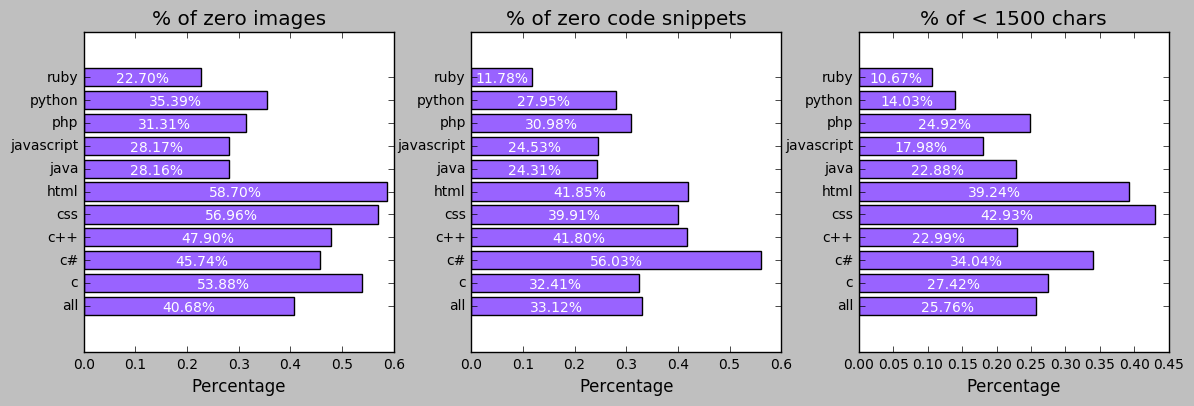

In [ ]:
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.rcParams['figure.figsize'] = 14, 4
import numpy as np
import matplotlib.pyplot as plt

# Draw plots
for i in range(len(feats)):
    feat = feats[i]
    plt.subplot(100 + 10 * len(feats) + (i + 1))
    plt.subplots_adjust(wspace=.25)
    # Example data
    names = tuple(sort(langs))
    y_pos = np.arange(len(names))
    performance = np.array(getPercentage(feat, zeroPercentage, sort(langs)))

    ax = plt.barh(y_pos, performance, align='center', color="#9963ff")
    plt.yticks(y_pos, names, size="small")
    plt.xlabel('Percentage')
    plt.xticks(size="small")
    if feat == "numImg":
        plt.title('% of zero images')
    elif feat == "numPre":
        plt.title('% of zero code snippets')
    elif feat == "totalLength":
        plt.title('% of < 1500 chars')

    rects = ax.patches
    labels = list(performance)

    for rect, label in zip(rects, labels):
        height = rect.get_y()
        plt.text(rect.get_width()/2, height + 0.03,"%.2f" % (label * 100) + "%",
                 ha='center', va='bottom', color="#FFFFFF", size="small")

plt.show()

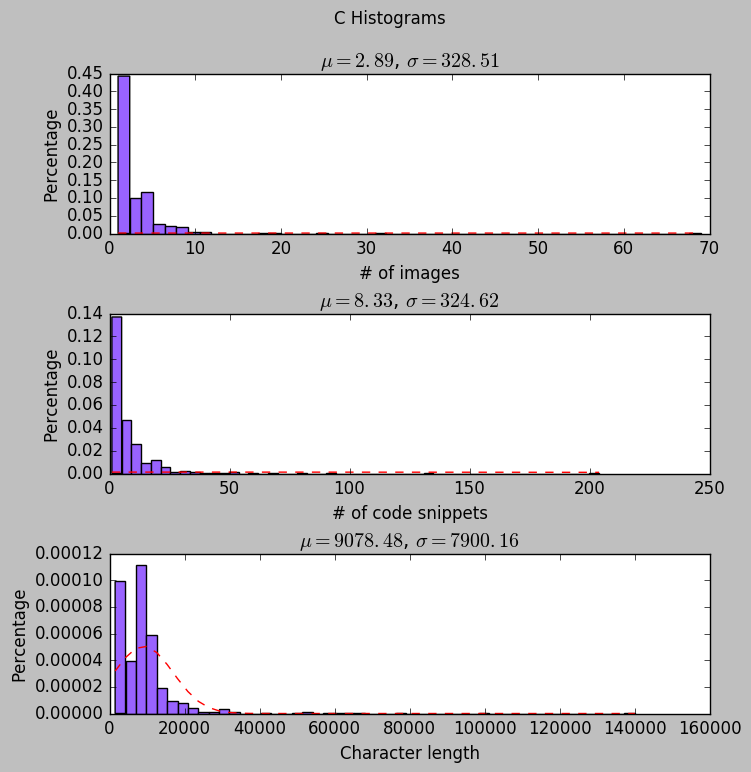

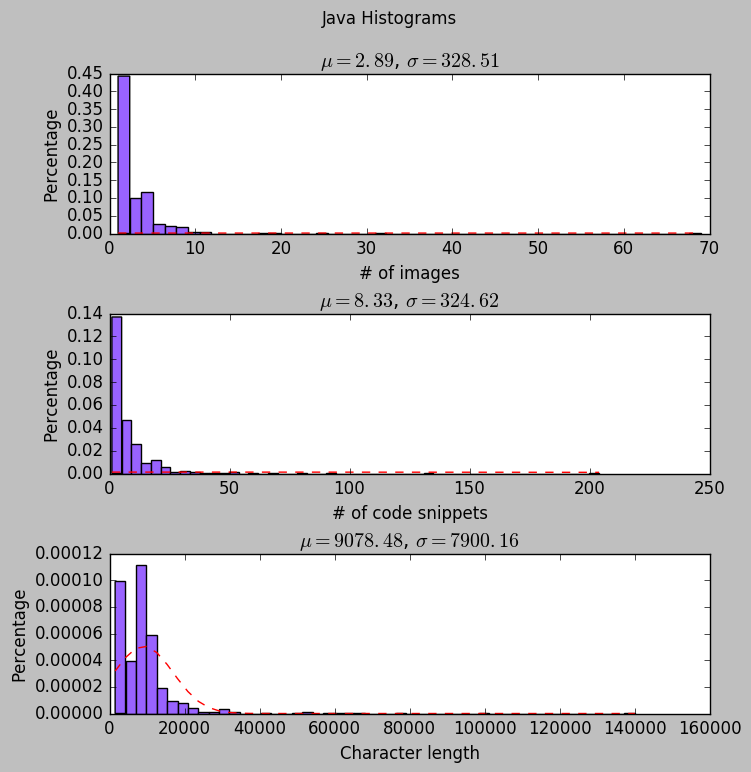

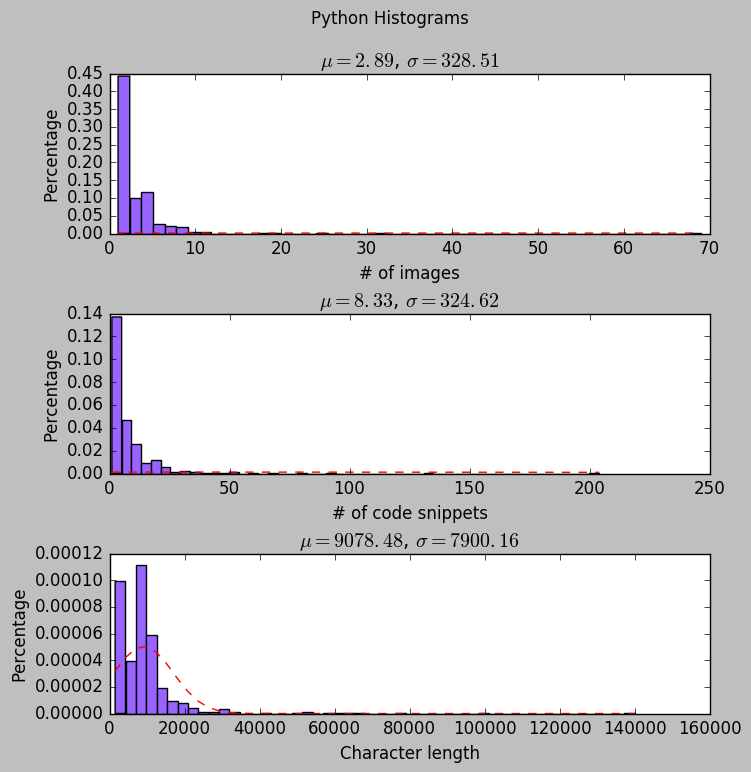

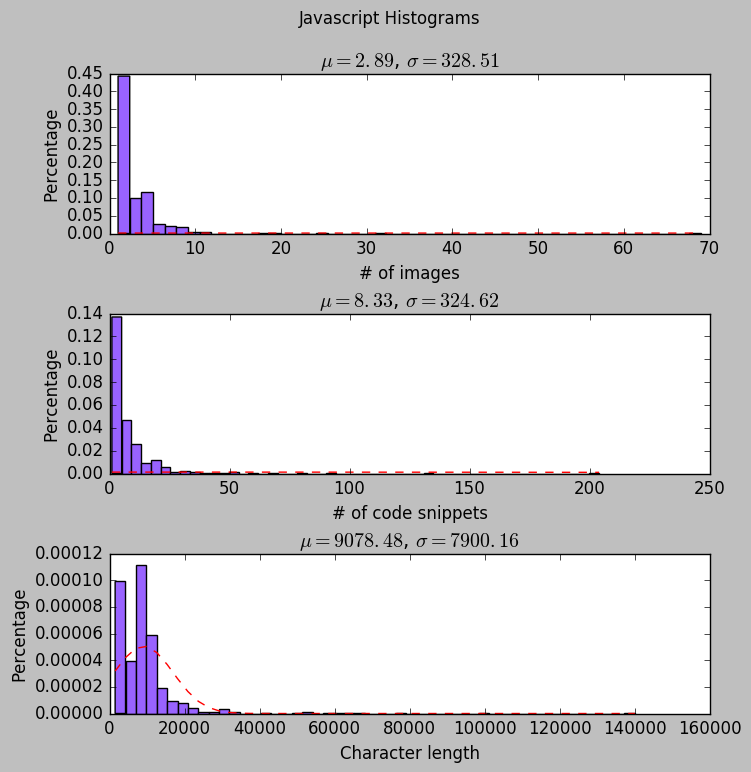

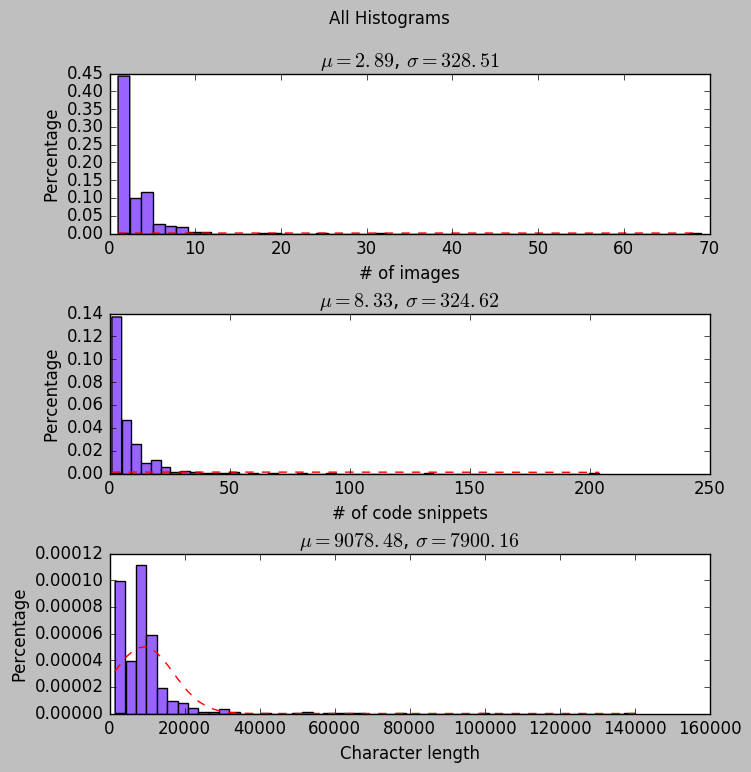

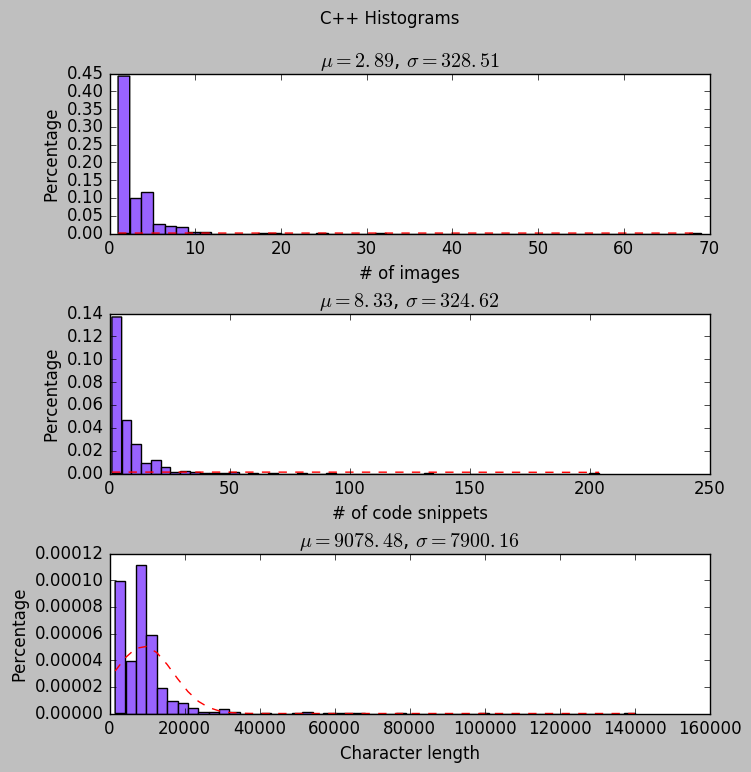

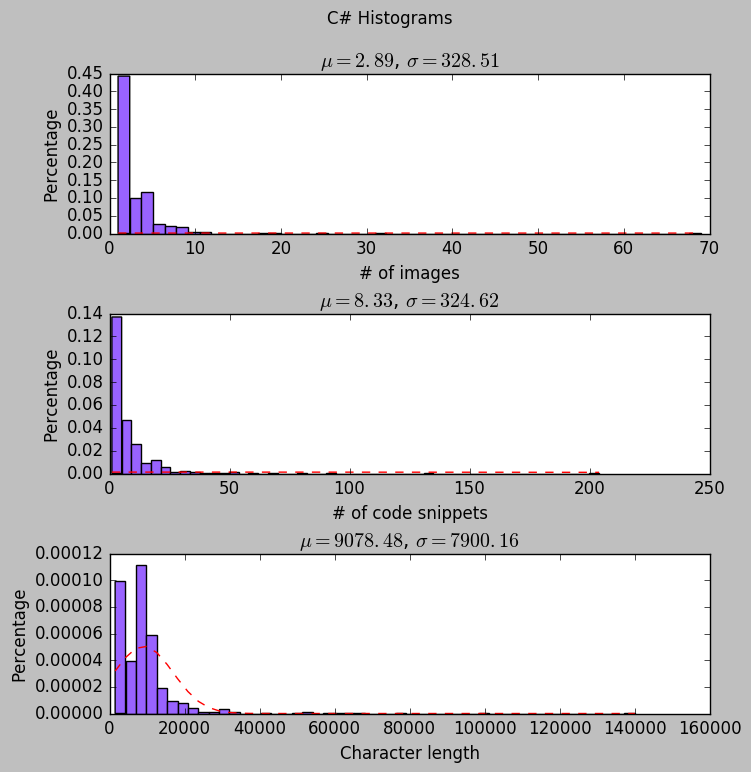

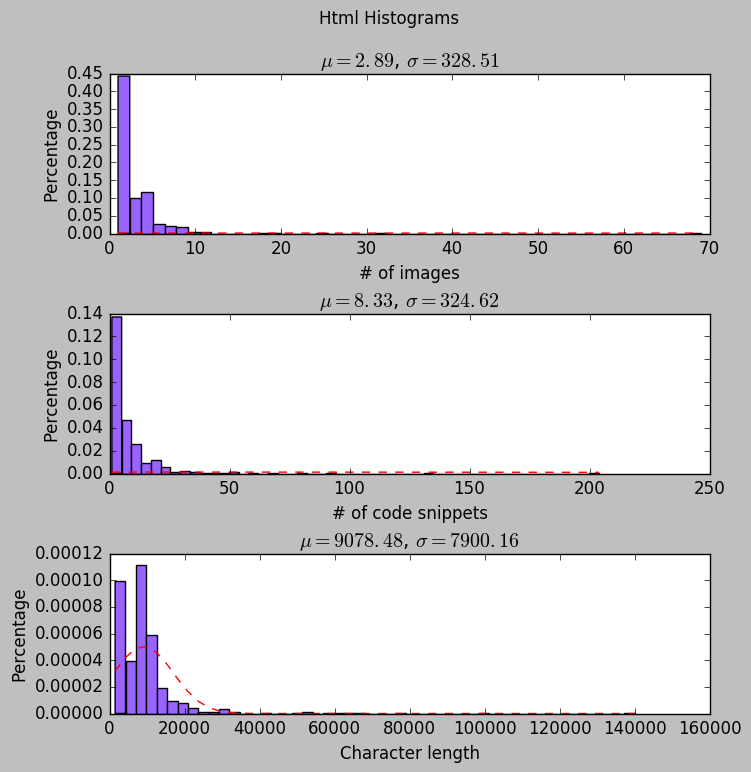

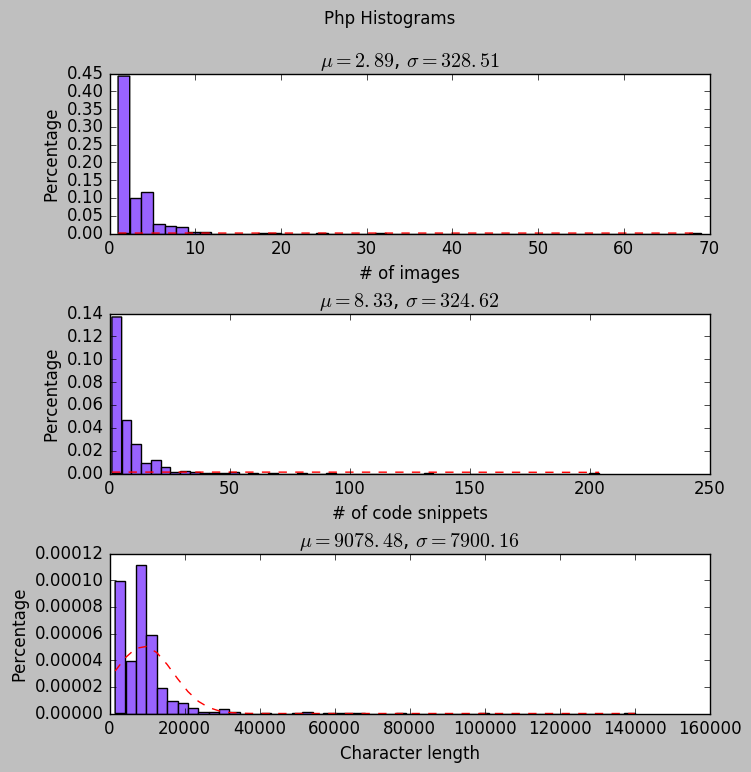

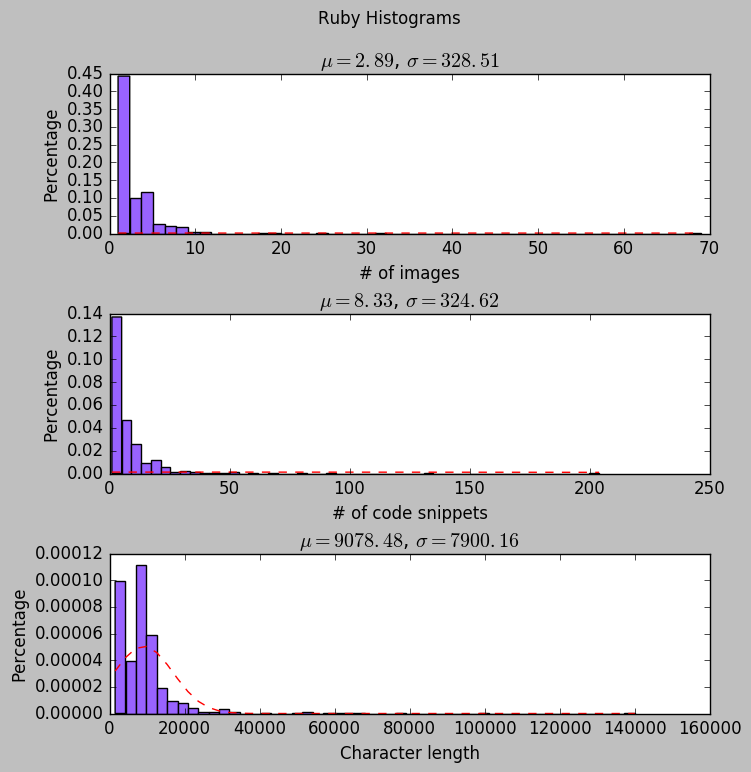

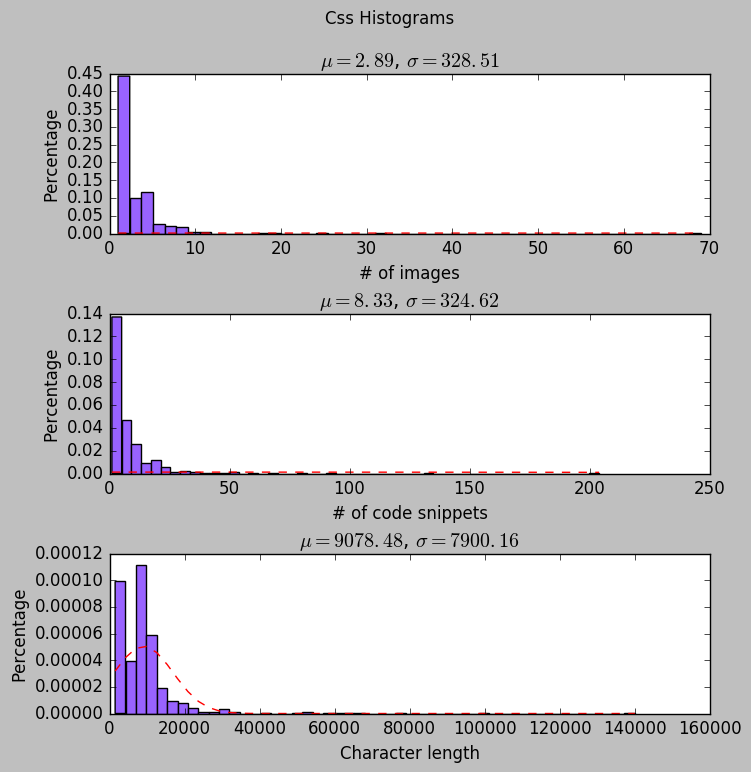

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.rcParams['figure.figsize'] = 8, 8

# draw plots
for lang in langs:
    for i in range(len(feats)):
        feat = feats[i]
        plt.subplot(310 + (i + 1))
        plt.subplots_adjust(hspace=.5)
        # data
        x = np.array(map(lambda x: x[0], filtered_stats["python"][feat]))
        mu = np.mean(map(lambda x: x[0], filtered_stats["python"][feat]))  # mean of distribution
        sigma = np.std(array(filtered_stats["python"][feat]))  # standard deviation of distribution

        num_bins = 50
        # the histogram of the data
        n, bins, patches = plt.hist(x, num_bins, normed=1, facecolor='#9963ff')
        # add a 'best fit' line
        y = mlab.normpdf(bins, mu, sigma)
        plt.plot(bins, y, 'r--')
        plt.ylabel('Percentage')
        if feat == "numImg":
            plt.title('$\mu=' + "%.2f" % mu + '$, $\sigma=' + "%.2f" % sigma + '$')
            plt.xlabel('# of images')
        elif feat == "numPre":
            plt.title('$\mu=' + "%.2f" % mu + '$, $\sigma=' + "%.2f" % sigma + '$')
            plt.xlabel('# of code snippets')
        elif feat == "totalLength":
            plt.xlabel('Character length')
            plt.title('$\mu=' + "%.2f" % mu + '$, $\sigma=' + "%.2f" % sigma + '$')

        # Tweak spacing to prevent clipping of ylabel
        plt.subplots_adjust(left=0.15)
    plt.suptitle(lang[0].upper() + lang[1:] + " Histograms")
    plt.show()

## 3.2. Preparing Data

In [ ]:
from nltk.stem import SnowballStemmer

stop_words = ["a","about","above","across","after","again","against","all","almost","alone","along","already","also",
              "although","always","among","an","and","another","any","anybody","anyone","anything","anywhere","are",
              "area","areas","around","as","ask","asked","asking","asks","at","away","b","back","backed","backing",
              "backs","be","became","because","become","becomes","been","before","began","behind","being","beings",
              "best","better","between","big","both","but","by","c","came","can","cannot","case","cases","certain",
              "certainly","clear","clearly","come","could","d","did","differ","different","differently","do","does",
              "done","down","down","downed","downing","downs","during","e","each","early","either","end","ended",
              "ending","ends","enough","even","evenly","ever","every","everybody","everyone","everything","everywhere",
              "f","face","faces","fact","facts","far","felt","few","find","finds","first","for","four","from","full",
              "fully","further","furthered","furthering","furthers","g","gave","general","generally","get","gets",
              "give","given","gives","go","going","good","goods","got","great","greater","greatest","group","grouped",
              "grouping","groups","h","had","has","have","having","he","her","here","herself","high","high","high",
              "higher","highest","him","himself","his","how","however","i","if","important","in","interest",
              "interested","interesting","interests","into","is","it","its","itself","j","just","k","keep","keeps",
              "kind","knew","know","known","knows","l","large","largely","last","later","latest","least","less","let",
              "lets","like","likely","long","longer","longest","m","made","make","making","man","many","may","me",
              "member","members","men","might","more","most","mostly","mr","mrs","much","must","my","myself","n",
              "necessary","need","needed","needing","needs","never","new","new","newer","newest","next","no","nobody",
              "non","noone","not","nothing","now","nowhere","number","numbers","o","of","off","often","old","older",
              "oldest","on","once","one","only","open","opened","opening","opens","or","order","ordered","ordering",
              "orders","other","others","our","out","over","p","part","parted","parting","parts","per","perhaps",
              "place","places","point","pointed","pointing","points","possible","present","presented","presenting",
              "presents","problem","problems","put","puts","q","quite","r","rather","really","right","right","room",
              "rooms","s","said","same","saw","say","says","second","seconds","see","seem","seemed","seeming","seems",
              "sees","several","shall","she","should","show","showed","showing","shows","side","sides","since",
              "small","smaller","smallest","so","some","somebody","someone","something","somewhere","state","states",
              "still","still","such","sure","t","take","taken","than","that","the","their","them","then","there",
              "therefore","these","they","thing","things","think","thinks","this","those","though","thought",
              "thoughts","three","through","thus","to","today","together","too","took","toward","turn","turned",
              "turning","turns","two","u","under","until","up","upon","us","use","used","uses","v","very","w","want",
              "wanted","wanting","wants","was","way","ways","we","well","wells","went","were","what","when","where",
              "whether","which","while","who","whole","whose","why","will","with","within","without","work","worked",
              "working","works","would","x","y","year","years","yet","you","young","younger","youngest","your",
              "yours","z"]

ss = SnowballStemmer("english")

stop_words = list(set([ss.stem(i) for i in stop_words]))

In [ ]:
%%capture
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split, cross_val_score
from numpy import array

#scaler = MinMaxScaler(feature_range=(0.5, 1.0))

prepared_data = {}

languages.append("all")

for lang in languages:
    prepared_data[lang] = {}
    
    # Initialize vectorizers
    h_tfidf = TfidfVectorizer(min_df = 0.04, max_df = 0.96, stop_words=stop_words)
    p_tfidf = TfidfVectorizer(min_df = 0.04, max_df = 0.96, stop_words=stop_words)
    #h_v1g = CountVectorizer(ngram_range=(1, 1), token_pattern=r'\b\w+\b', min_df=1)
    #p_v1g = CountVectorizer(ngram_range=(1, 1), token_pattern=r'\b\w+\b', min_df=1)
    #v4g = CountVectorizer(ngram_range=(1, 4), token_pattern=r'\b\w+\b', min_df=1)
    #v3g = CountVectorizer(ngram_range=(1, 3), token_pattern=r'\b\w+\b', min_df=1)
    
    # Filter out readme's that have 0 images, 0 code snippets, and are shorther than 1500 characters.
    pr_all = zip(pr_X[lang], pr_y[lang])
    pr_all = filter(lambda x: x[0] != 0, pr_all)
    pr_X[lang], pr_y[lang] = zip(*pr_all)
    
    i_all = zip(i_X[lang], i_y[lang])
    i_all = filter(lambda x: x[0] != 0, i_all)
    i_X[lang], i_y[lang] = zip(*i_all)
    
    l_all = zip(l_X[lang], l_y[lang])
    l_all = filter(lambda x: x[0] > 1500, l_all)
    l_X[lang], l_y[lang] = zip(*l_all)
    
    ## Header
    X_n = h_tfidf.fit_transform(h_X[lang])
    y_s = array(h_y[lang])

    X_n_train, X_n_test, y_s_train, y_s_test = train_test_split(X_n, y_s, test_size=0.25, random_state=42)
    
    prepared_data[lang]["header"] = {}
    prepared_data[lang]["header"]["X_n"] = X_n
    prepared_data[lang]["header"]["y_s"] = y_s
    prepared_data[lang]["header"]["X_n_train"] = X_n_train
    prepared_data[lang]["header"]["X_n_test"] = X_n_test
    prepared_data[lang]["header"]["y_s_train"] = y_s_train
    prepared_data[lang]["header"]["y_s_test"] = y_s_test
    prepared_data[lang]["header"]["v1g"] = h_tfidf
    
    ## Paragraph
    X_n = p_tfidf.fit_transform(p_X[lang])
    y_s = array(p_y[lang])

    X_n_train, X_n_test, y_s_train, y_s_test = train_test_split(X_n, y_s, test_size=0.25, random_state=42)
    
    prepared_data[lang]["paragraph"] = {}
    prepared_data[lang]["paragraph"]["X_n"] = X_n
    prepared_data[lang]["paragraph"]["y_s"] = y_s
    prepared_data[lang]["paragraph"]["X_n_train"] = X_n_train
    prepared_data[lang]["paragraph"]["X_n_test"] = X_n_test
    prepared_data[lang]["paragraph"]["y_s_train"] = y_s_train
    prepared_data[lang]["paragraph"]["y_s_test"] = y_s_test
    prepared_data[lang]["paragraph"]["v1g"] = p_tfidf
    
    # Number of Pre tags
    X_n = array(pr_X[lang])
    y_s = array(pr_y[lang])

    X_n_train, X_n_test, y_s_train, y_s_test = train_test_split(X_n, y_s, test_size=0.25, random_state=42)
    
    prepared_data[lang]["pre"] = {}
    prepared_data[lang]["pre"]["X_n"] = X_n
    prepared_data[lang]["pre"]["y_s"] = y_s
    prepared_data[lang]["pre"]["X_n_train"] = X_n_train
    prepared_data[lang]["pre"]["X_n_test"] = X_n_test
    prepared_data[lang]["pre"]["y_s_train"] = y_s_train
    prepared_data[lang]["pre"]["y_s_test"] = y_s_test
    
    # Number of Img tags
    X_n = array(i_X[lang])
    y_s = array(i_y[lang])

    X_n_train, X_n_test, y_s_train, y_s_test = train_test_split(X_n, y_s, test_size=0.25, random_state=42)
    
    prepared_data[lang]["img"] = {}
    prepared_data[lang]["img"]["X_n"] = X_n
    prepared_data[lang]["img"]["y_s"] = y_s
    prepared_data[lang]["img"]["X_n_train"] = X_n_train
    prepared_data[lang]["img"]["X_n_test"] = X_n_test
    prepared_data[lang]["img"]["y_s_train"] = y_s_train
    prepared_data[lang]["img"]["y_s_test"] = y_s_test
    
    # Readme length
    X_n = array(l_X[lang])
    y_s = array(l_y[lang])

    X_n_train, X_n_test, y_s_train, y_s_test = train_test_split(X_n, y_s, test_size=0.25, random_state=42)
    
    prepared_data[lang]["length"] = {}
    prepared_data[lang]["length"]["X_n"] = X_n
    prepared_data[lang]["length"]["y_s"] = y_s
    prepared_data[lang]["length"]["X_n_train"] = X_n_train
    prepared_data[lang]["length"]["X_n_test"] = X_n_test
    prepared_data[lang]["length"]["y_s_train"] = y_s_train
    prepared_data[lang]["length"]["y_s_test"] = y_s_test

## 3.1 Benchmarking
Our whole assumption is based on that the top 1000 repositories for each language are the best type of readmes a developer can write.

nuSVM was removed because it has no direct interpretation. (http://stackoverflow.com/questions/11230955/what-is-the-meaning-of-the-nu-parameter-in-scikit-learns-svm-class)

In [ ]:
import timeit
from numpy import ndarray
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import NearestCentroid
from sklearn.semi_supervised import LabelPropagation
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier

models = {}
scores = {}
timer = {}

features = ["header", "paragraph", "pre", "img", "length"]

def init_classifiers():
    classifiers = {}
    classifiers["LogisticRegression"] = {"model": LogisticRegression()}
    classifiers["PassiveAggressiveClassifier"] = {"model": PassiveAggressiveClassifier()}
    classifiers["GaussianNB"] = {"model": GaussianNB()}
    classifiers["MultinomialNB"] = {"model": MultinomialNB()}
    classifiers["BernoulliNB"] = {"model": BernoulliNB()}
    classifiers["NearestCentroid"] = {"model": NearestCentroid()}
    classifiers["LabelPropagation"] = {"model": LabelPropagation()}
    classifiers["SVC"] = {"model": SVC()}
    classifiers["LinearSVC"] = {"model": LinearSVC()}
    classifiers["DecisionTreeClassifier"] = {"model": DecisionTreeClassifier()}
    classifiers["ExtraTreeClassifier"] = {"model": ExtraTreeClassifier()}
    
    return classifiers
c = 0
for lang in languages:
    models[lang] = {}
    scores[lang] = {}
    timer[lang] = {}
    
    for feature in features:
        classifiers = init_classifiers()
        models[lang][feature] = {}
        scores[lang][feature] = {}
        timer[lang][feature] = {}
        
        for name in classifiers:
            clf = classifiers[name]["model"]
            X = prepared_data[lang][feature]["X_n_train"]
            y = prepared_data[lang][feature]["y_s_train"]
            X_test = prepared_data[lang][feature]["X_n_test"]
            y_test = prepared_data[lang][feature]["y_s_test"]
            if feature in ["pre", "img", "length"]:
                X = X.reshape(-1,1)
                X_test = X_test.reshape(-1,1)
            # start timing
            if name in ["LabelPropagation", "GaussianNB"]:
                X = X.toarray() if not isinstance(X, ndarray) else X
                X_test = X_test.toarray() if not isinstance(X_test, ndarray) else X_test
            print "Language: " + lang
            print "Classifier: " + name
            print "Feature: " + feature
            print "================================="
            start = timeit.default_timer()
            clf.fit(X, y)
            # end timing
            stop = timeit.default_timer()
            timer[lang][feature][name] = stop - start
            
            predictions = clf.predict(X_test)
            true_values = y_test
            classifiers[name]["predictor"] = clf
            scores[lang][feature][name] = mean_squared_error(predictions, true_values)
            
        # Get the best model
        models[lang][feature]["model"] = classifiers[min(scores[lang][feature], key=scores[lang][feature].get)]["predictor"]
        models[lang][feature]["type"] = min(scores[lang][feature], key=scores[lang][feature].get)
        # add v1g objects to the models object
        if feature in ["header", "paragraph"]:
            models[lang][feature]["v1g"] = prepared_data[lang][feature]["v1g"]
        

In [ ]:
def getPercentage2(scores, classifiers):
    rVal = []
    for cls in classifiers:
        rVal.append(scores[cls])

    return rVal

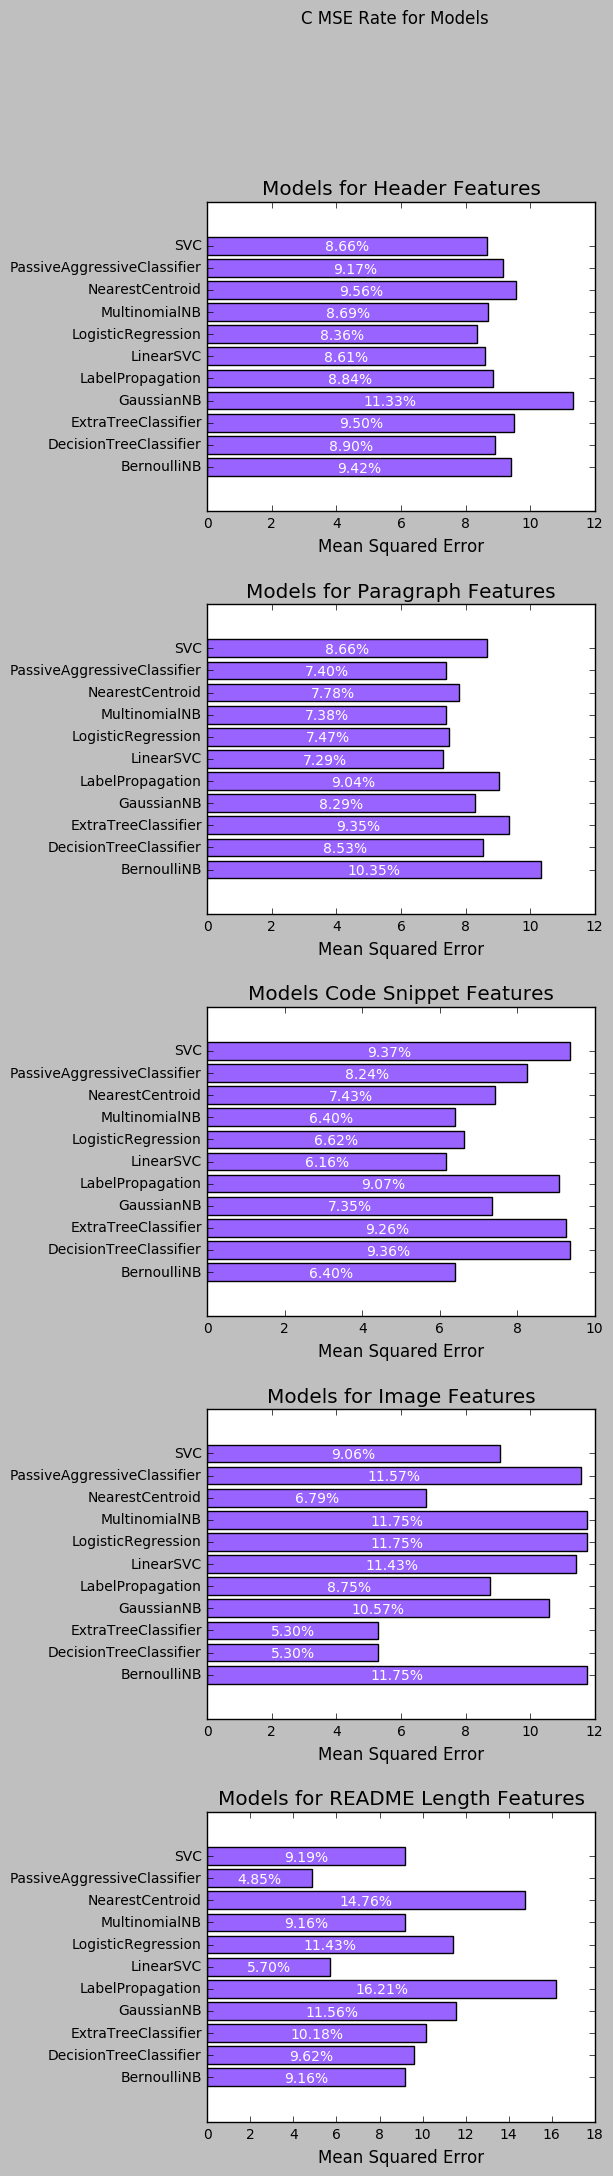

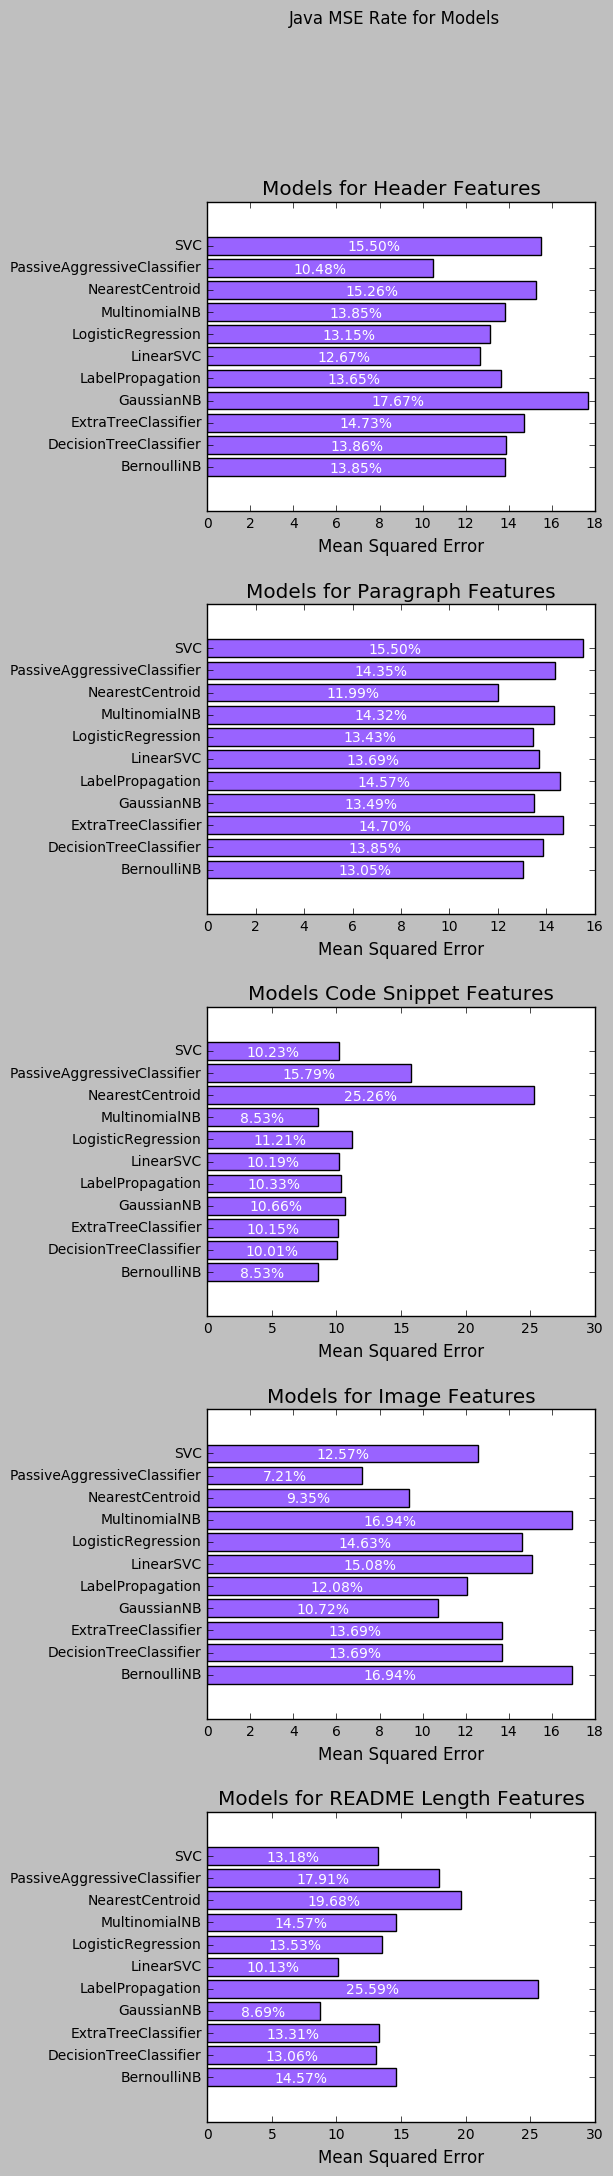

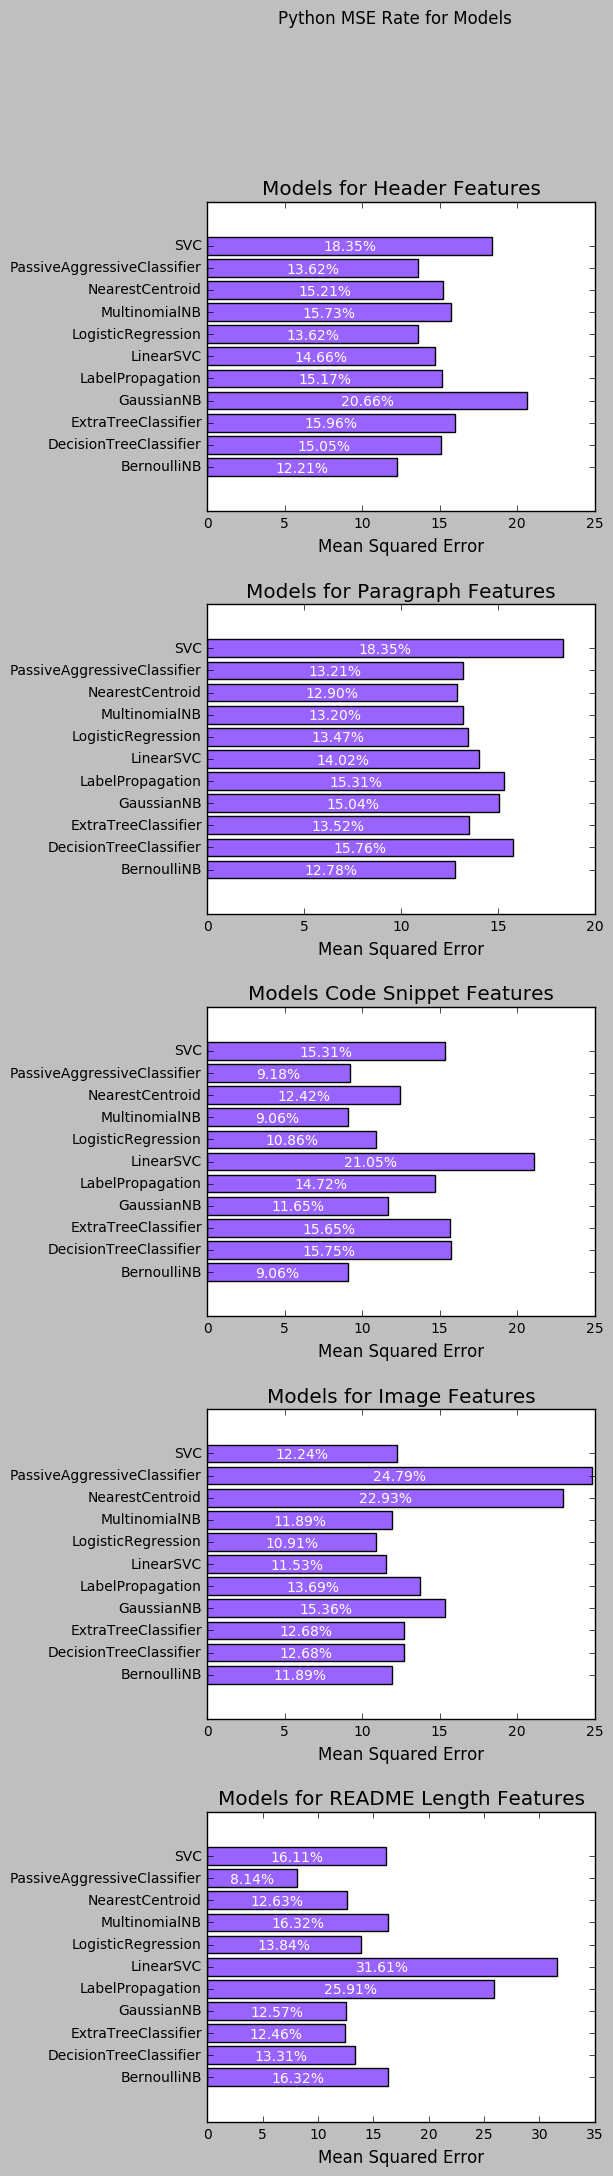

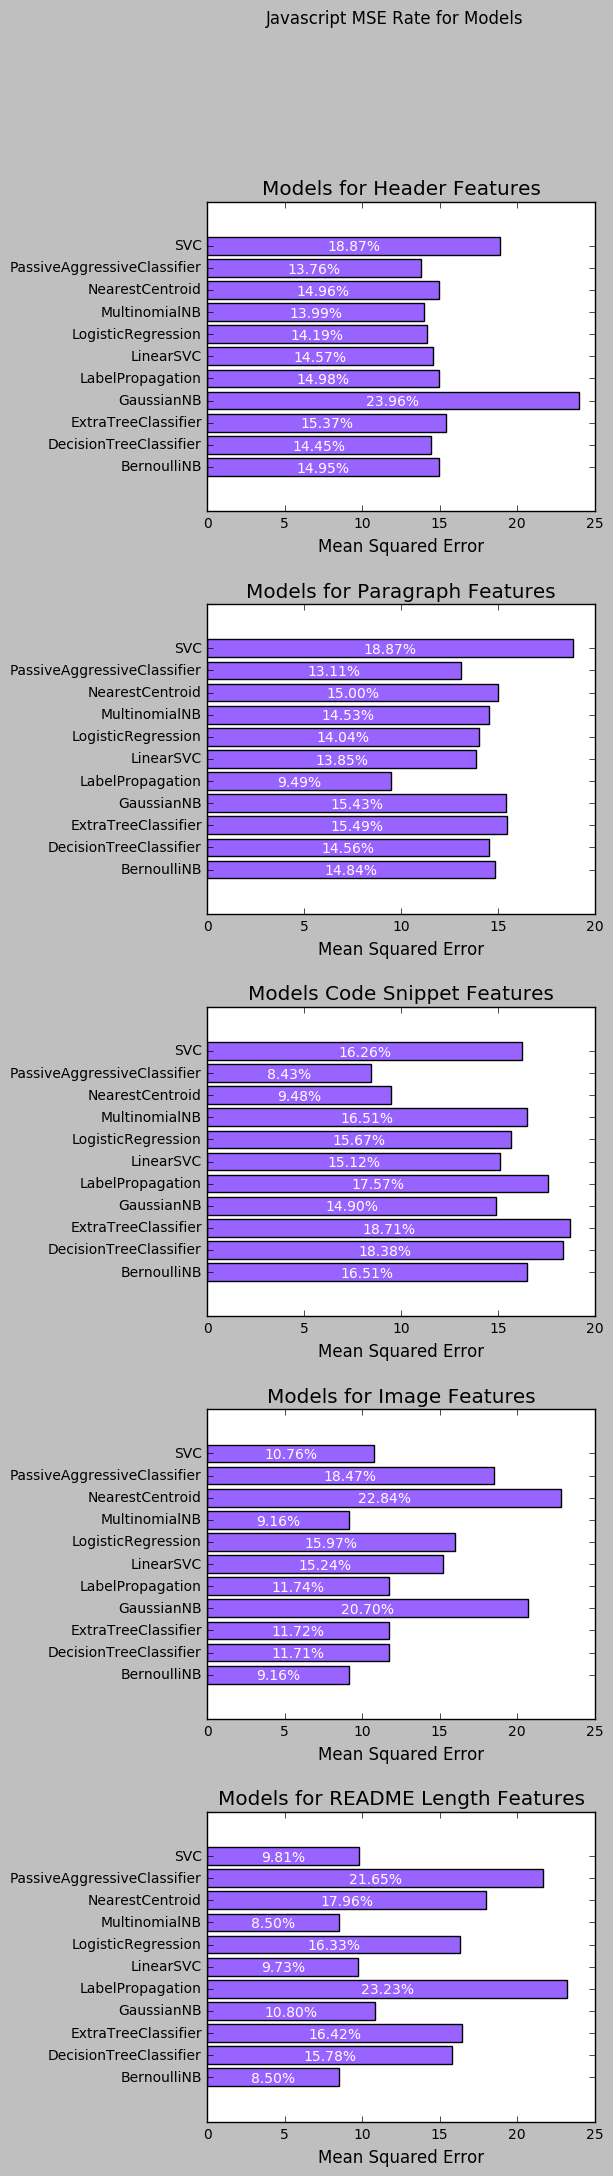

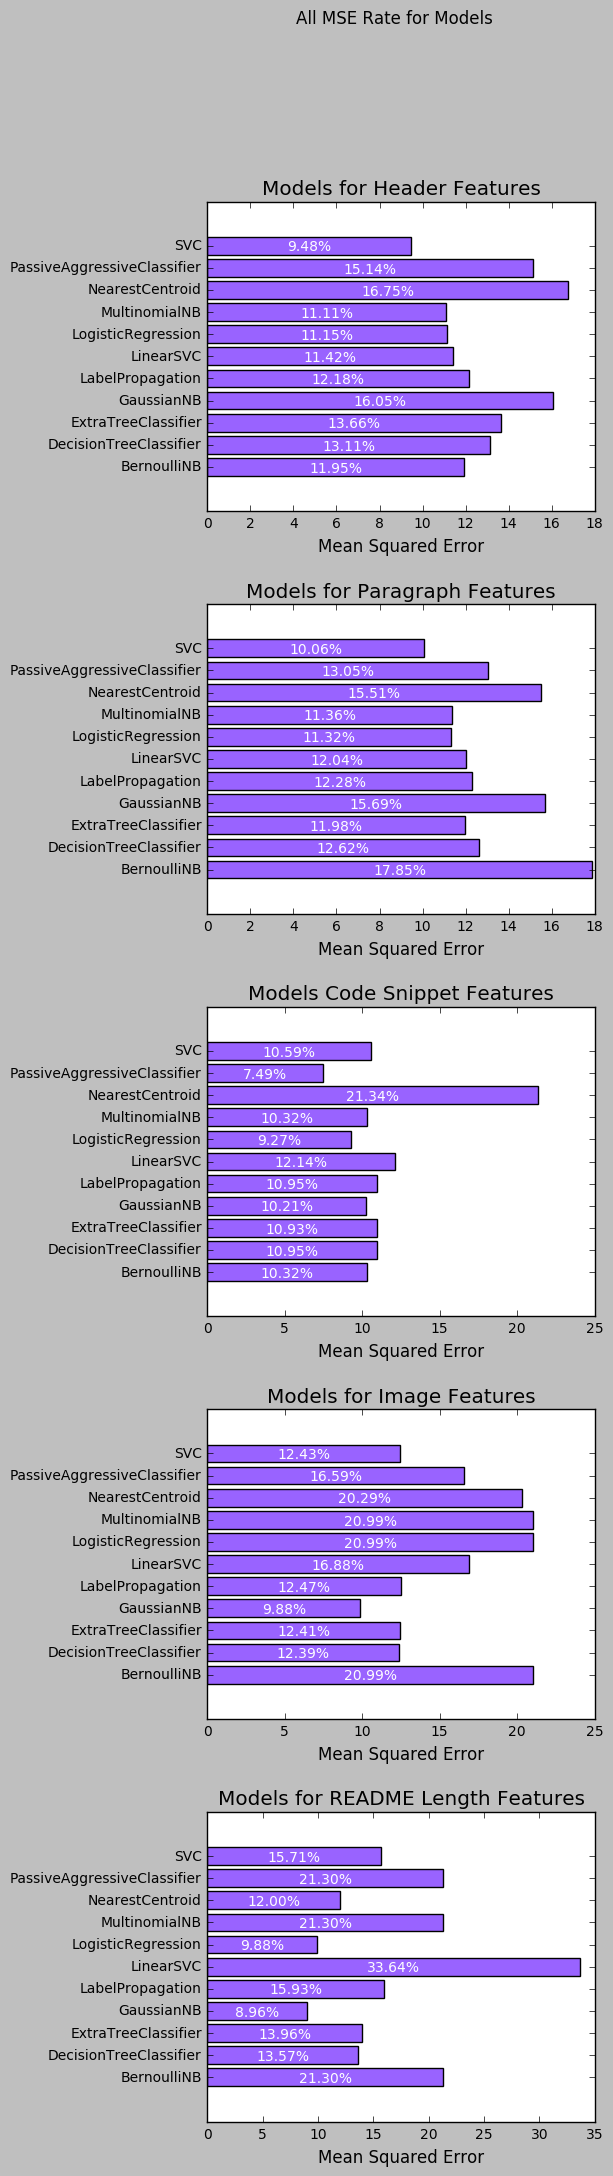

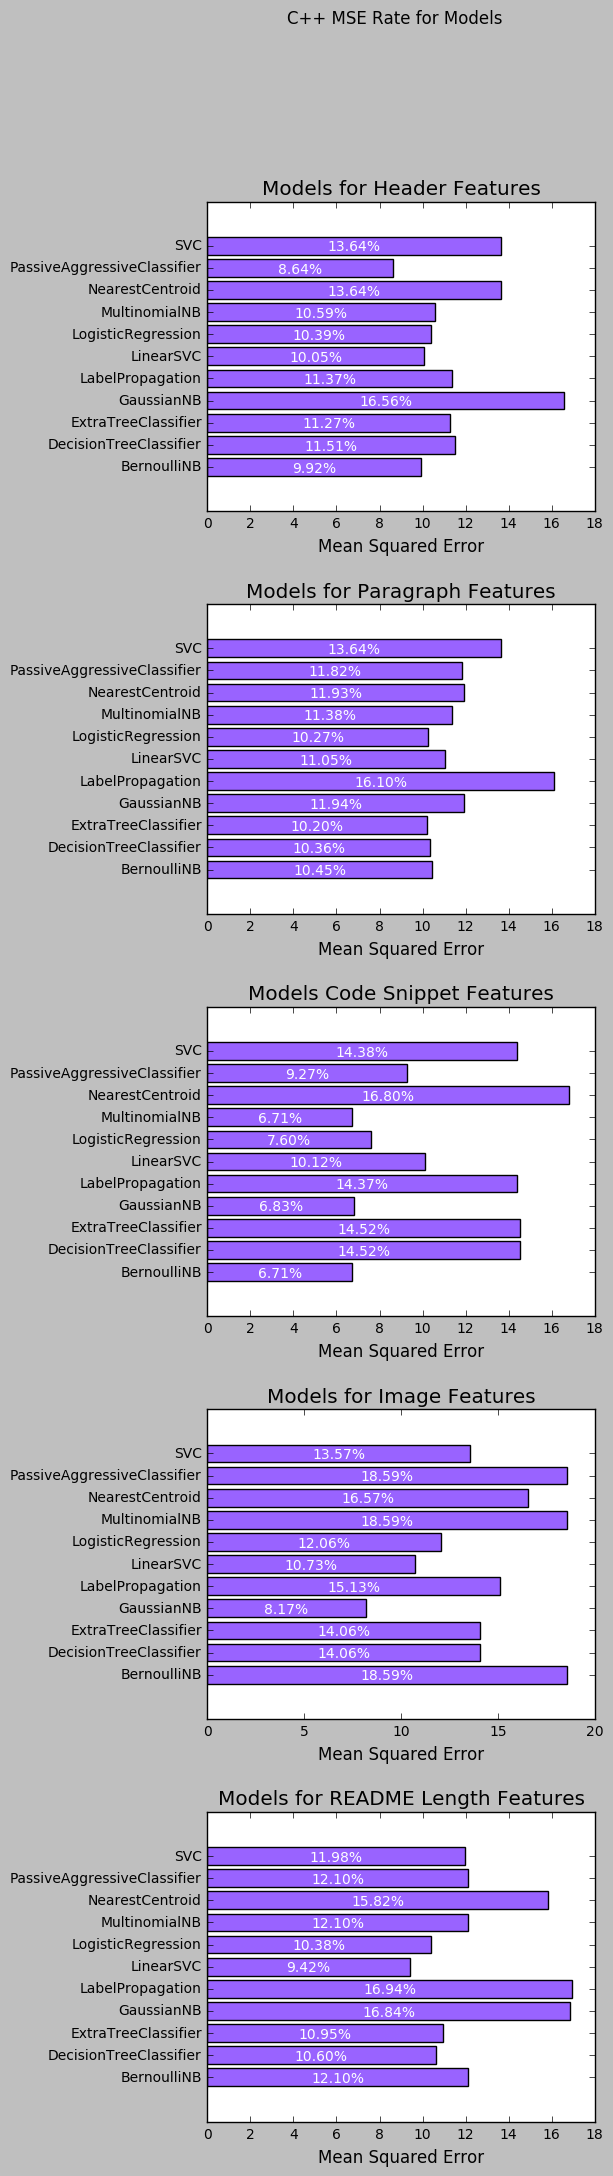

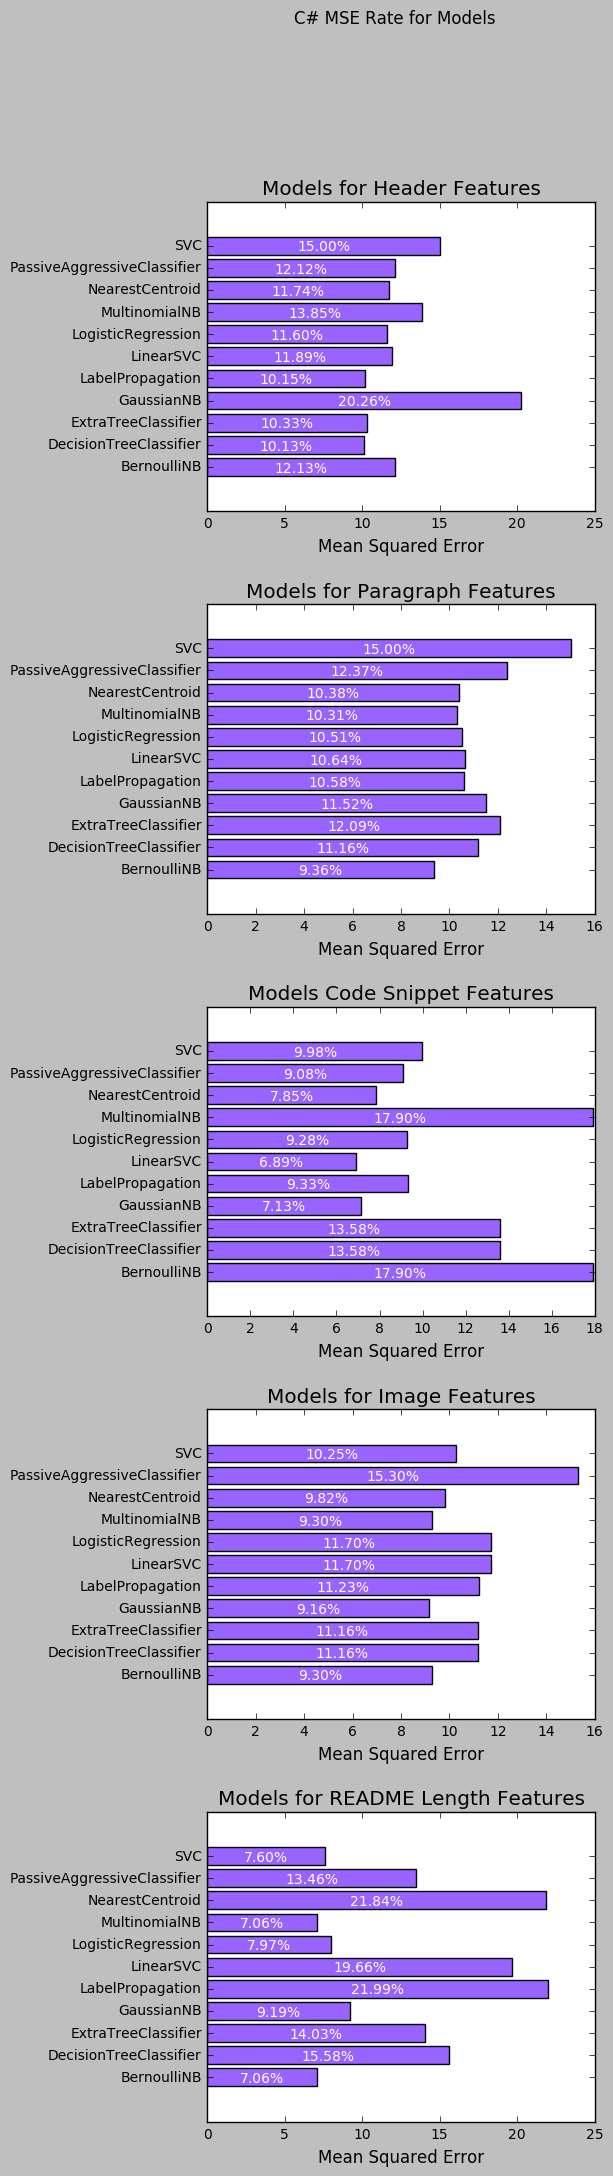

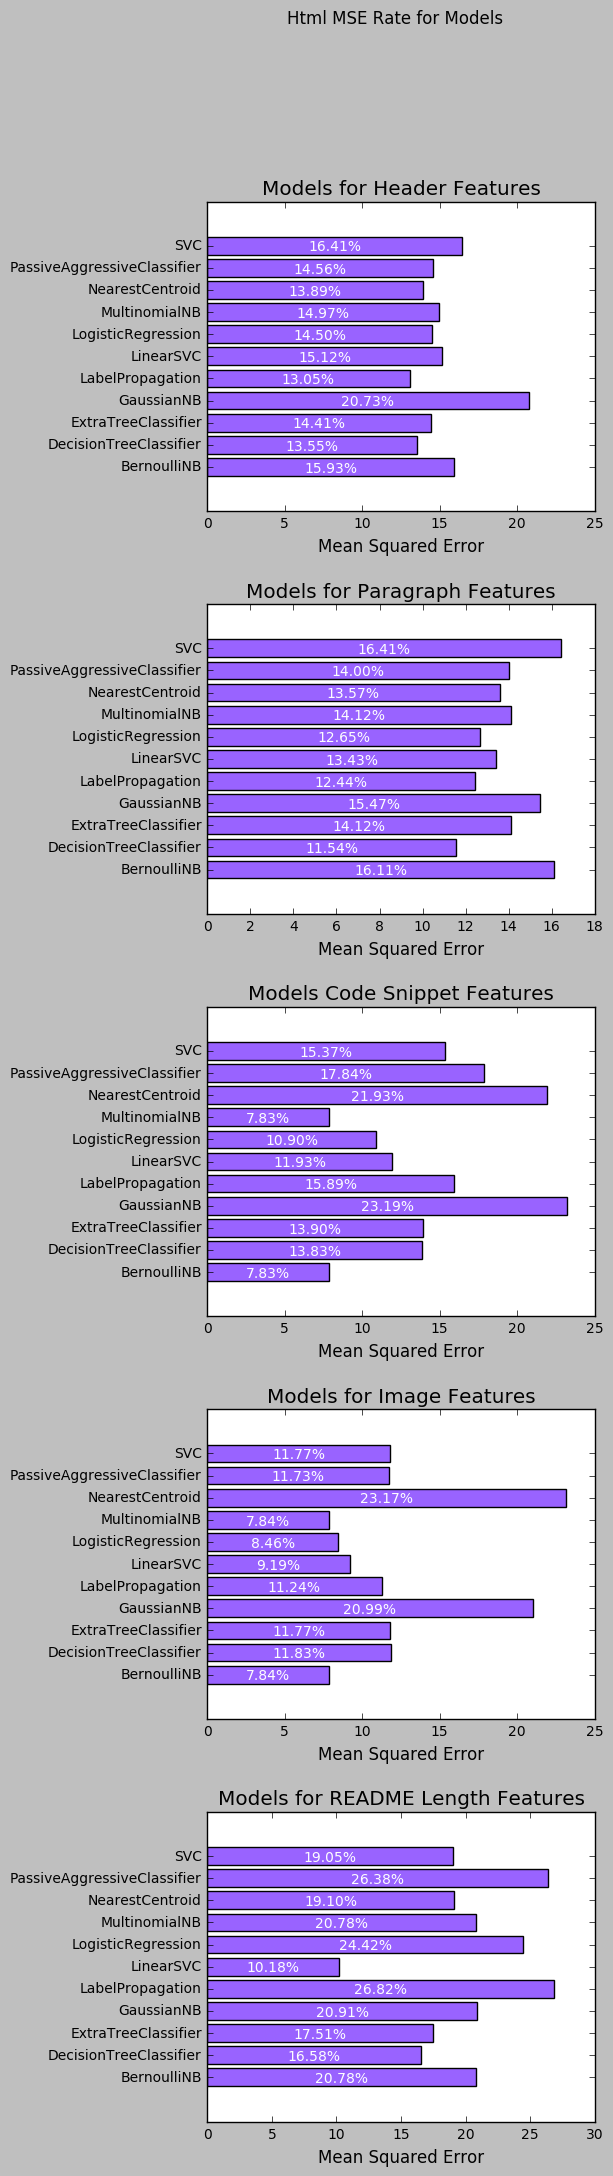

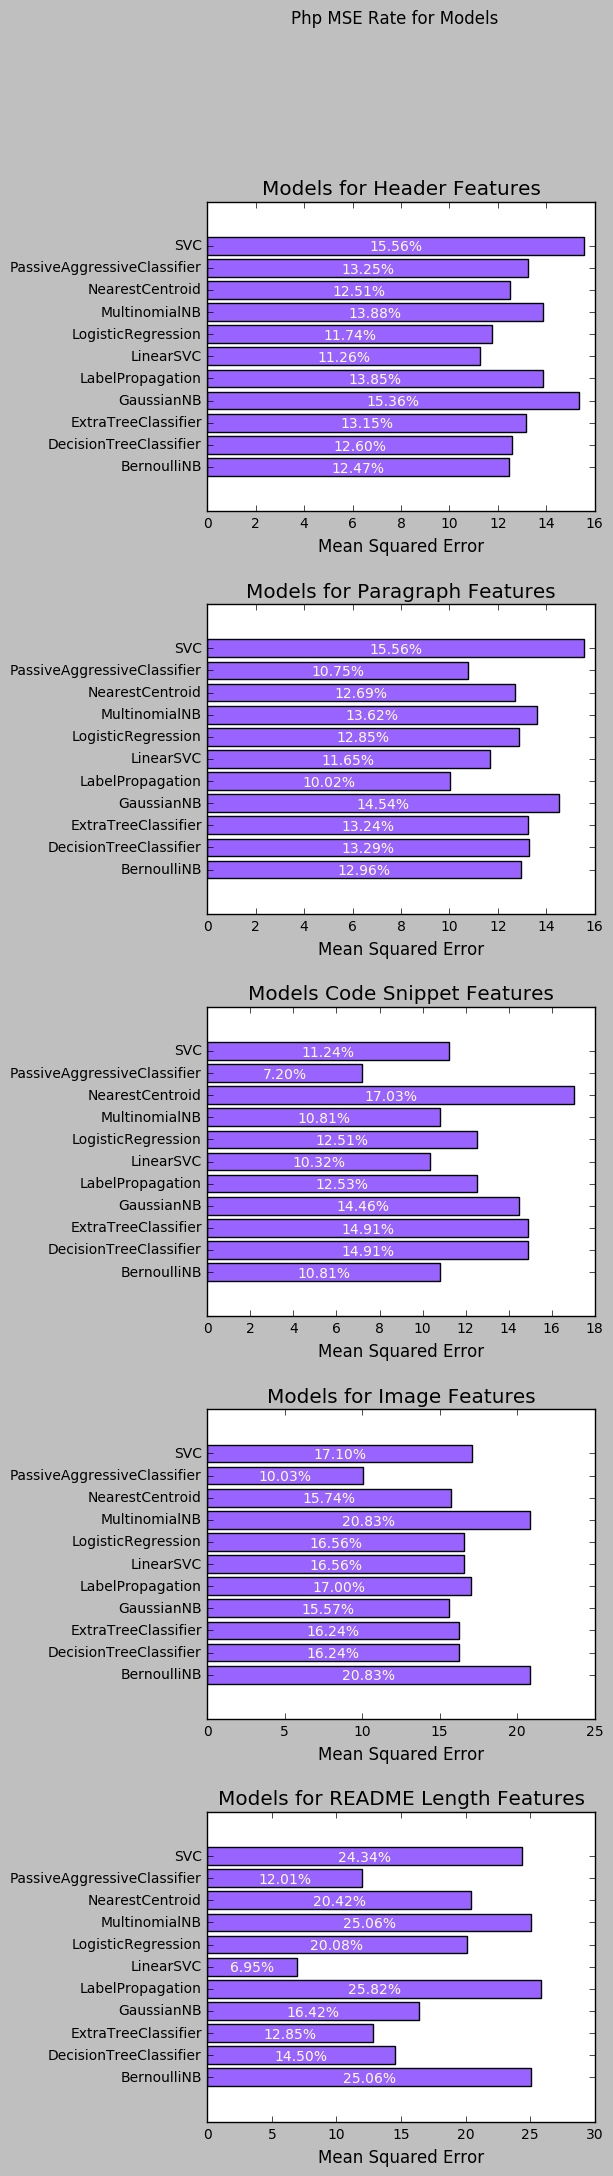

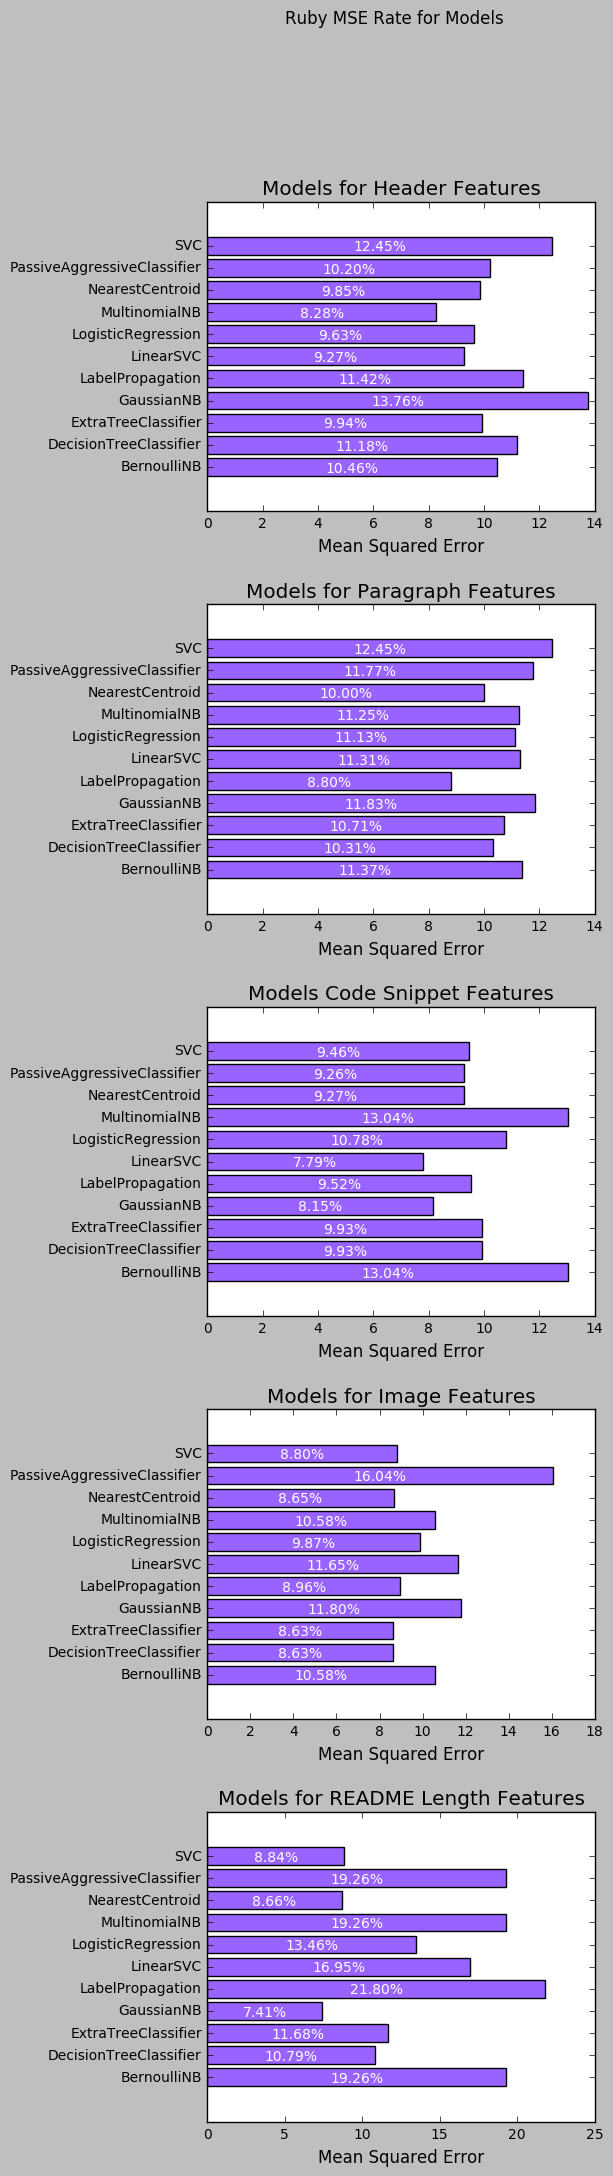

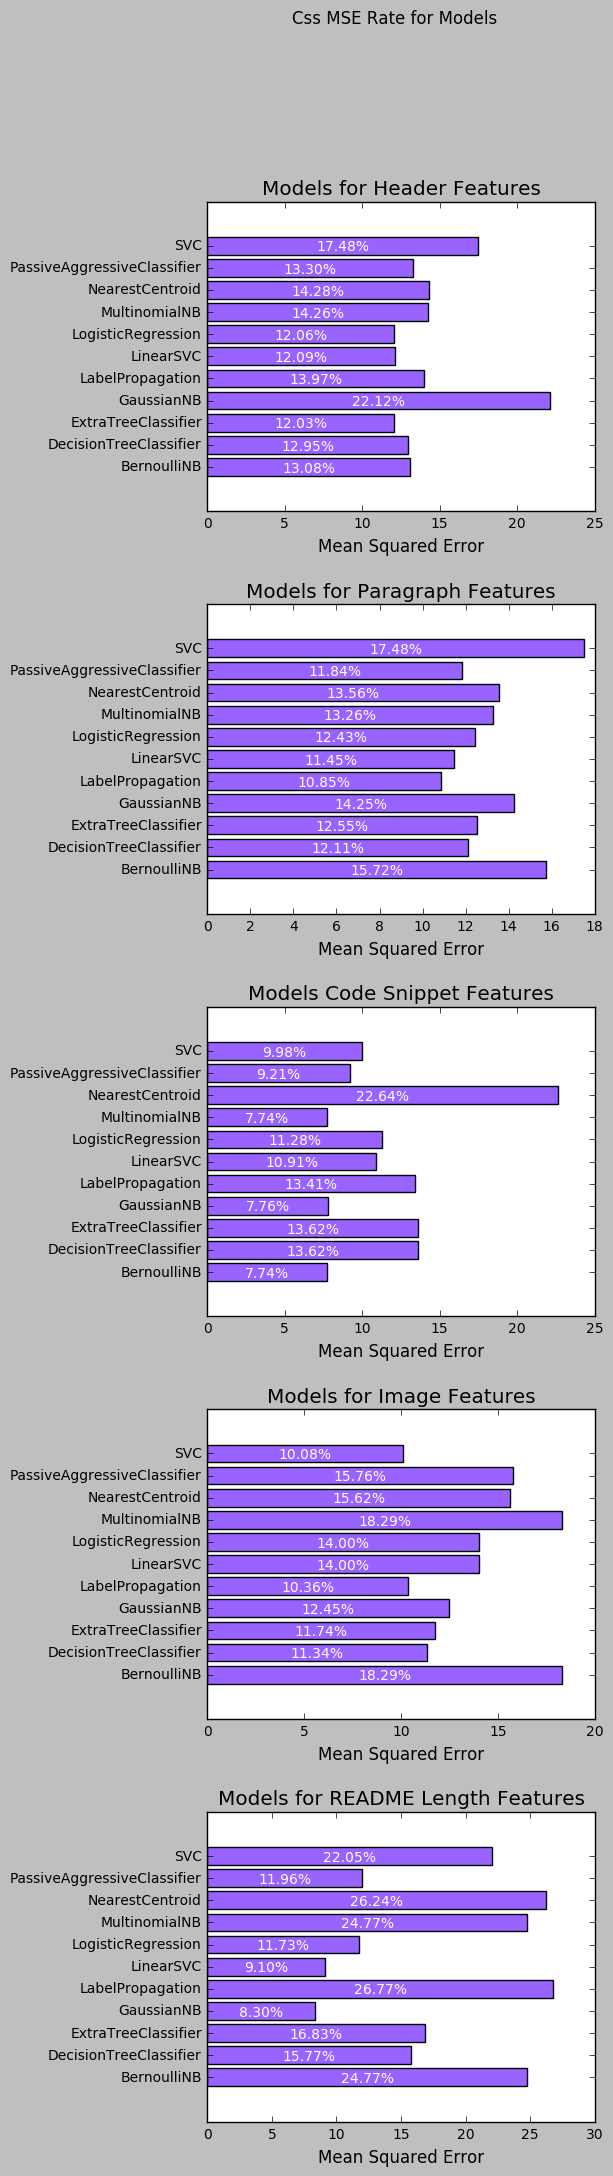

In [ ]:
## Plotting Accuracy scores for benchmarked models
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.rcParams['figure.figsize'] = 5, 24
import numpy as np
import matplotlib.pyplot as plt

#scores[lang][feature][name]

classifiers = ["BernoulliNB", "DecisionTreeClassifier", "ExtraTreeClassifier",
               "GaussianNB", "LabelPropagation", "LinearSVC", "LogisticRegression",
               "MultinomialNB", "NearestCentroid", "PassiveAggressiveClassifier", "SVC"]

feats = ["header", "paragraph", "pre", "img", "length"]

# Draw plots
for lang in langs:
    for i in range(len(feats)):
        feat = feats[i]
        plt.subplot(100 * len(feats) + 10 + (i + 1))
        plt.subplots_adjust(hspace=.3)
        # Example data
        names = tuple(sort(classifiers))
        y_pos = np.arange(len(names))
        performance = np.array(getPercentage2(scores[lang][feat], classifiers))

        ax = plt.barh(y_pos, performance, align='center', color="#9963ff")
        plt.yticks(y_pos, names, size="small")
        plt.xlabel('Mean Squared Error')
        plt.xticks(size="small")
        if feat == "img":
            plt.title('Models for Image Features')
        elif feat == "pre":
            plt.title('Models Code Snippet Features')
        elif feat == "length":
            plt.title('Models for README Length Features')
        elif feat == "header":
            plt.title("Models for Header Features")
        elif feat == "paragraph":
            plt.title("Models for Paragraph Features")

        rects = ax.patches
        labels = list(performance)

        for rect, label in zip(rects, labels):
            height = rect.get_y()
            plt.text(rect.get_width()/2, height + 0.03,"%.2f" % label + "%",
                     ha='center', va='bottom', color="#FFFFFF", size="small")

    plt.suptitle(lang[0].upper() + lang[1:] + " MSE Rate for Models")
    plt.show()

In [ ]:
import pickle

# persist model file
output = open("models.pkl", "wb")

pickle.dump(models, output)
output.close()

In [ ]:
import pickle

# persist conjugation dictionaries
output = open("h_conj.pkl", "wb")

pickle.dump(h_conj_map, output)
output.close()

output = open("p_conj.pkl", "wb")

pickle.dump(p_conj_map, output)
output.close()

## 4. Scoring Github Readmes
First pull the file from the given url.

In [ ]:
import pickle
import zipfile

# extract zipped files
zip_ref = zipfile.ZipFile("models.pkl.zip", 'r')
zip_ref.extract("models.pkl")
zip_ref.close()

zip_ref = zipfile.ZipFile("h_conj.pkl.zip", 'r')
zip_ref.extract("h_conj.pkl")
zip_ref.close()

zip_ref = zipfile.ZipFile("p_conj.pkl.zip", 'r')
zip_ref.extract("p_conj.pkl")
zip_ref.close()

# load model file into memory
file_handle = open("models.pkl", "rb")

models = pickle.load(file_handle)

file_handle.close()

# load conjugation files
file_handle = open("h_conj.pkl", "rb")

h_conj = pickle.load(file_handle)

file_handle.close()

file_handle = open("p_conj.pkl", "rb")

p_conj = pickle.load(file_handle)

file_handle.close()

In [ ]:
import mistune
import urllib
import string
from numpy import array
from docutils import core
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import SnowballStemmer

def html_parts(input_string, source_path=None, destination_path=None,
               input_encoding='unicode', doctitle=True,
               initial_header_level=1):
    """
    Given an input string, returns a dictionary of HTML document parts.

    Dictionary keys are the names of parts, and values are Unicode strings;
    encoding is up to the client.

    Parameters:

    - `input_string`: A multi-line text string; required.
    - `source_path`: Path to the source file or object.  Optional, but useful
      for diagnostic output (system messages).
    - `destination_path`: Path to the file or object which will receive the
      output; optional.  Used for determining relative paths (stylesheets,
      source links, etc.).
    - `input_encoding`: The encoding of `input_string`.  If it is an encoded
      8-bit string, provide the correct encoding.  If it is a Unicode string,
      use "unicode", the default.
    - `doctitle`: Disable the promotion of a lone top-level section title to
      document title (and subsequent section title to document subtitle
      promotion); enabled by default.
    - `initial_header_level`: The initial level for header elements (e.g. 1
      for "<h1>").
    """
    overrides = {'input_encoding': input_encoding,
                 'doctitle_xform': doctitle,
                 'initial_header_level': initial_header_level}
    parts = core.publish_parts(
        source=input_string, source_path=source_path,
        destination_path=destination_path,
        writer_name='html', settings_overrides=overrides)
    return parts

def parseMarkdown(md):
    '''
    Returns HTML
    '''
    return mistune.markdown(md)


def parseRestructuredtext(rst):
    '''
    Returns HTML
    '''
    return html_parts(rst)["whole"]

In [ ]:
example_readme_url = "https://raw.githubusercontent.com/algorithmiaio/algorithmia-python/master/README.md"

languages = ["javascript", "java", "ruby", "python", "php", "html", "css", "c++", "c", "c#", "all"]

given_language = "all"

if given_language.lower() not in languages:
    raise ValueError("Language (" + given_language + ") is not supported")

file_format = example_readme_url.split(".")[-1].lower()

given_readme = urllib.urlopen(example_readme_url).read()

In [ ]:
vectorizer = {}

vectorizer["header"] = models[given_language.lower()]["header"]["v1g"]
vectorizer["paragraph"] = models[given_language.lower()]["paragraph"]["v1g"]

translate_table = dict((ord(char), None) for char in string.punctuation)

ss = SnowballStemmer("english")

if file_format == "md":
    html = parseMarkdown(given_readme)
elif file_format == "rst":
    html = parseRestructuredtext(given_readme.decode("utf-8"))

bs = BeautifulSoup(html, "lxml")

# remove new lines, remove punctuation and stem words
headlines = [i.get_text().replace("\n", " ").translate(translate_table) for i in bs.find_all("h1")]
headlines += [i.get_text().replace("\n", " ").translate(translate_table) for i in bs.find_all("h2")]
headlines += [i.get_text().replace("\n", " ").translate(translate_table) for i in bs.find_all("h3")]
headlines = [" ".join([ss.stem(j.lower()) for j in i.split()]) for i in headlines]
headlines = [" ".join(headlines)]
paragraphs = [i.get_text().replace("\n", " ").translate(translate_table) for i in bs.find_all("p")]
paragraphs = [" ".join([ss.stem(j.lower()) for j in i.split()]) for i in paragraphs]
paragraphs = [" ".join(paragraphs)]

input_vector = {}

input_vector["img"] = array(len(bs.find_all("img")))
input_vector["pre"] = array(len(bs.find_all("pre")))
input_vector["length"] = len(bs.get_text())
input_vector["header"] = vectorizer["header"].transform(headlines)
input_vector["paragraph"] = vectorizer["paragraph"].transform(paragraphs)


In [ ]:
# Get scores for each features
standard_results = {}

standard_results["header"] = int(models[given_language.lower()]["header"]["model"].predict(input_vector["header"])[0])
standard_results["paragraph"] = int(models[given_language.lower()]["paragraph"]["model"].predict(input_vector["paragraph"])[0])
standard_results["pre"] = int(models[given_language.lower()]["pre"]["model"].predict(input_vector["pre"])[0])
standard_results["img"] = int(models[given_language.lower()]["img"]["model"].predict(input_vector["img"])[0])
standard_results["length"] = int(models[given_language.lower()]["length"]["model"].predict(input_vector["length"])[0])

print standard_results

In [ ]:
# Improve score by flipping binary words in feature vectors

features = ["header", "paragraph", "pre", "img", "length"]


improved_results = {}

for feature in features:
    improved_results[feature] = []
    # Find a better local minima for the feature
    X = input_vector[feature]
    # works only for text
    if feature in ["header", "paragraph"]:
        for j in range(X.shape[1]):
            if X[0, j] == 0:
                X[0, j] = 1
                res = models[given_language.lower()][feature]["model"].predict(X)
                res = int(res[0])
                improved_results[feature].append(res)
                X[0, j] = 0
            elif X[0, j] == 1:
                X[0, j] = 0
                res = models[given_language.lower()][feature]["model"].predict(X)
                res = int(res[0])
                improved_results[feature].append(res)
                X[0, j] = 1
    elif feature in ["pre", "img"]:
        # decrease length in single increments from %200 to %0
        if int(X) == 0:
            pass
        elif int(X) > 0:
            # down to %0
            for i in range(int(X)):
                new_val = array(int(X) - i - 1)
                res = models[given_language.lower()][feature]["model"].predict(new_val)
                improved_results[feature].append(res)
            # up to %200
            for i in range(2 * int(X)):
                new_val = array(int(X) + i + 1)
                res = models[given_language.lower()][feature]["model"].predict(new_val)
                improved_results[feature].append(res)
    elif feature in ["length"]:
        # increase & decrease length in %10 increments from %0 to %200
        if int(X) > 20:
            for i in range(21):
                new_val = array(int(int(X) * 0.1 * (20 - i)))
                res = models[given_language.lower()][feature]["model"].predict(new_val)
                improved_results[feature].append(res)
            

In [ ]:
import heapq
import operator
import random

changes = {}
conj = {"header": h_conj, "paragraph": p_conj}

for feature in features:
    if feature in ["header", "paragraph"]:
        top_n_changes = heapq.nlargest(10, enumerate(improved_results[feature]), key=operator.itemgetter(1))

        indel = None
        
        changes[feature] = []

        for i in top_n_changes:
            if vectorizer[feature].vocabulary_.keys()[i[0]] in headlines[0].split():
                indel = "delete"
            elif vectorizer[feature].vocabulary_.keys()[i[0]] not in headlines[0].split():
                indel = "insert"
            else:
                indel = None
            # only show changes that are useful
            if i[1] >= standard_results[feature]:
                val = random.choice(conj[feature][given_language.lower()][vectorizer[feature].vocabulary_.keys()[i[0]]])
                changes[feature].append({"value": val, "operation": indel})
    elif feature in ["pre", "img", "length"]:
        top_n_changes = heapq.nlargest(10, enumerate(improved_results[feature]), key=operator.itemgetter(1))
        
        oper = None
        
        changes[feature] = []
        
        if len(top_n_changes) > 0:
            i = top_n_changes[0]
            if i[0] > input_vector[feature]:
                oper = "increase"
            elif i[0] < input_vector[feature]:
                oper = "decrease"
            if i[1] >= standard_results[feature]:
                changes[feature].append({"value": i[0], "operation": oper})
        
        """
        for i in top_n_changes:
            if i[0] > input_vector[feature]:
                oper = "addition"
            elif i[0] < input_vector[feature]:
                oper = "subtraction"
            if i[1] >= standard_results[feature]:
                changes[feature].append({"value": i[0], "operation": oper})
        """
        
print changes